# Imports

In [1]:
import os
import sys

import torch
import yaml

sys.path.append(os.path.abspath(os.path.join('..')))

import local_datasets

import init_training

from codecarbon import EmissionsTracker

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
import time
from IPython.display import clear_output

from torchinfo import summary

import pandas as pd

import numpy as np

import tracemalloc

import torch
from torchvision.transforms import functional as TF

# Cfg

In [2]:
# change working directory if not /home/mappel/Dynaphos/viseon
if os.getcwd().split("/")[-1] != "viseon":
    os.chdir("/home/mappel/Dynaphos/viseon")

In [3]:
def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

experiment_yaml = [ './_config/exp1-snellius/128x128_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin64x64_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov64x64_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin32x32_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov32x32_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin16x16_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov16x16_contrained_boundary.yaml']


# load configs into dict
config = [load_config(yaml_file) for yaml_file in experiment_yaml]
config = {key: value for key, value in zip(['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov'], config)}

In [4]:
experiments = ['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov']

summaries = {}

for experiment in experiments:
    cfg = config[experiment]
    testset = local_datasets.get_lapa_dataset(cfg, split='test')
    models = init_training.get_models(cfg)

    encoder = models['encoder']

    encoder.load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_encoder.pth'))
    encoder.eval()
    encoder.to('cuda')

    # based on cfg
    input_size = (1, 3, cfg['imsize'][0], cfg['imsize'][1])

    summary_ = summary(encoder, input_size=input_size)
    summaries[experiment] = summary_

In [5]:
# show one summary
print(summaries['128x128'])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1024]                 --
├─E2E_Encoder: 1-1                       [1, 1024]                 --
│    └─Sequential: 2-1                   [1, 1024]                 --
│    │    └─Conv2d: 3-1                  [1, 8, 128, 128]          216
│    │    └─BatchNorm2d: 3-2             [1, 8, 128, 128]          16
│    │    └─LeakyReLU: 3-3               [1, 8, 128, 128]          --
│    │    └─Conv2d: 3-4                  [1, 16, 128, 128]         1,152
│    │    └─BatchNorm2d: 3-5             [1, 16, 128, 128]         32
│    │    └─LeakyReLU: 3-6               [1, 16, 128, 128]         --
│    │    └─MaxPool2d: 3-7               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-8                  [1, 32, 64, 64]           4,608
│    │    └─BatchNorm2d: 3-9             [1, 32, 64, 64]           64
│    │    └─LeakyReLU: 3-10              [1, 32, 64, 64]           --
│    │  

# Calculate transform Memory and Mult-Adds

Let calculate the memory and the mult-adds usage.

In [6]:
# import PIL
from PIL import Image

In [7]:
def get_memory_usage(transform):
    random_array = np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8)
    random_image = Image.fromarray(random_array)
    transform(random_image)

    tracemalloc.start()
    transform(random_image)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak

In [8]:
# get testset for all the configurations
testsets = {experiment: local_datasets.get_lapa_dataset(config[experiment], split='test') for experiment in experiments}

memory_compression = {}

for experiment in experiments:
    transform = testsets[experiment]._create_image_transform()
    memory_compression[experiment] = get_memory_usage(transform)

memory_compression

{'128x128': 98913,
 '64x64lin': 66025,
 '64x64fov': 2059451,
 '32x32lin': 66025,
 '32x32fov': 1842091,
 '16x16lin': 66025,
 '16x16fov': 1788427}

In [9]:
# now compare multadds for 64x64, 32x32, 16x16

def calculate_multadds(transform):

    # Save original NumPy functions
    original_add = np.add
    original_mul = np.multiply

    def add_wrapper(x, y, *args, **kwargs):
        operation_counter["add"] += x.size if hasattr(x, "size") else 1  # Avoid np.size
        return original_add(x, y, *args, **kwargs)

    def mul_wrapper(x, y, *args, **kwargs):
        operation_counter["mul"] += x.size if hasattr(x, "size") else 1  # Avoid np.size
        return original_mul(x, y, *args, **kwargs)

    # Define a context manager to temporarily replace NumPy functions
    from contextlib import contextmanager

    @contextmanager
    def override_numpy_operations():
        try:
            np.add = add_wrapper
            np.multiply = mul_wrapper
            yield
        finally:
            np.add = original_add
            np.multiply = original_mul

    # Run the function with NumPy overrides in place
    random_array = np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8)
    random_image = Image.fromarray(random_array)
    transform(random_image)
    x = torch.rand(1, 3, 512, 512)

    operation_counter = {"add": 0, "mul": 0}  # Reset counters

    # Use the context manager to override NumPy operations
    with override_numpy_operations():
        transform(random_image)

    return operation_counter

# get testset for all the configurations
testsets = {experiment: local_datasets.get_lapa_dataset(config[experiment], split='test') for experiment in experiments}

multadds_dict = {}
for experiment in experiments:
    transform = testsets[experiment]._create_image_transform()
    # combine all the operations
    multadds_ = calculate_multadds(transform)
    total = multadds_["add"] + multadds_["mul"]
    multadds_dict[experiment] = total

multadds_dict

{'128x128': 0,
 '64x64lin': 0,
 '64x64fov': 12288,
 '32x32lin': 0,
 '32x32fov': 3072,
 '16x16lin': 0,
 '16x16fov': 768}

In [11]:
def calculate_mult_adds(input_size, output_size, channels, method):
    """
    Calculate multiply-add operations for downsampling.

    Parameters:
        input_size (tuple): Input dimensions as (height, width).
        output_size (tuple): Output dimensions as (height, width).
        channels (int): Number of channels (e.g., 3 for RGB).
        method (str): 'nearest' or 'bilinear'.

    Returns:
        int: Total multiply-add operations.
    """
    input_height, input_width = input_size
    output_height, output_width = output_size

    if method == 'nearest':
        # Nearest neighbor: no multiplications or additions
        return 0

    elif method == 'bilinear':
        # Bilinear interpolation: 9 MACs per output pixel per channel
        macs_per_pixel = 9
        total_macs = output_height * output_width * channels * macs_per_pixel
        return total_macs

    else:
        raise ValueError("Invalid method. Choose 'nearest' or 'bilinear'.")

# Example usage
input_size = (512, 512)
channels = 3
output_sizes = [(256, 256), (128, 128), (64, 64), (32, 32), (16, 16)]

for output_size in output_sizes:
    nearest_macs = calculate_mult_adds(input_size, output_size, channels, 'nearest')
    bilinear_macs = calculate_mult_adds(input_size, output_size, channels, 'bilinear')
    print(f"Output size {output_size}: Nearest MACs = {nearest_macs}, Bilinear MACs = {bilinear_macs}")


Output size (256, 256): Nearest MACs = 0, Bilinear MACs = 1769472
Output size (128, 128): Nearest MACs = 0, Bilinear MACs = 442368
Output size (64, 64): Nearest MACs = 0, Bilinear MACs = 110592
Output size (32, 32): Nearest MACs = 0, Bilinear MACs = 27648
Output size (16, 16): Nearest MACs = 0, Bilinear MACs = 6912


In [12]:
multadds_dict_complete = multadds_dict.copy()

for experiment in experiments:
    cfg = config[experiment]
    input_size = (256, 256)
    output_size = (cfg['imsize'][0]//2, cfg['imsize'][1]//2)
    channels = 3
    # method is bilinear if lin (and baseline 128) else nearest if fov
    method = 'bilinear' if 'lin' in experiment or '128' in experiment else 'nearest'
    multadds = calculate_mult_adds(input_size, output_size, channels, method)
    multadds_dict_complete[experiment] += multadds

multadds_dict_complete


{'128x128': 110592,
 '64x64lin': 27648,
 '64x64fov': 12288,
 '32x32lin': 6912,
 '32x32fov': 3072,
 '16x16lin': 1728,
 '16x16fov': 768}

In [13]:
multadds_compression = multadds_dict_complete.copy()
multadds_compression

{'128x128': 110592,
 '64x64lin': 27648,
 '64x64fov': 12288,
 '32x32lin': 6912,
 '32x32fov': 3072,
 '16x16lin': 1728,
 '16x16fov': 768}

In [ ]:
summaries['128x128'].total_input

[(1, 3, 128, 128)]

In [17]:
summaries['128x128']

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1024]                 --
├─E2E_Encoder: 1-1                       [1, 1024]                 --
│    └─Sequential: 2-1                   [1, 1024]                 --
│    │    └─Conv2d: 3-1                  [1, 8, 128, 128]          216
│    │    └─BatchNorm2d: 3-2             [1, 8, 128, 128]          16
│    │    └─LeakyReLU: 3-3               [1, 8, 128, 128]          --
│    │    └─Conv2d: 3-4                  [1, 16, 128, 128]         1,152
│    │    └─BatchNorm2d: 3-5             [1, 16, 128, 128]         32
│    │    └─LeakyReLU: 3-6               [1, 16, 128, 128]         --
│    │    └─MaxPool2d: 3-7               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-8                  [1, 32, 64, 64]           4,608
│    │    └─BatchNorm2d: 3-9             [1, 32, 64, 64]           64
│    │    └─LeakyReLU: 3-10              [1, 32, 64, 64]           --
│    │  

In [23]:
# Put all results in a df
df = pd.DataFrame({
    "Configuration": ["128x128 (bilin)", "64x64 (bilin)", "64x64 (Fov)", "32x32 (bilin)", "32x32 (Fov)", "16x16 (bilin)", "16x16 (Fov)"],
    "Total Parameters": [summaries[experiment].total_params for experiment in experiments],
    "Memory (Input)": [summaries[experiment].total_input for experiment in experiments],
    "Memory (Compr)": [memory_compression[experiment] for experiment in experiments],
    "Memory (Params)": [summaries['128x128'].total_param_bytes, summaries['64x64lin'].total_param_bytes, summaries['64x64fov'].total_param_bytes, summaries['32x32lin'].total_param_bytes, summaries['32x32fov'].total_param_bytes, summaries['16x16lin'].total_param_bytes, summaries['16x16fov'].total_param_bytes],
    "Memory (F/B Pass)": [summaries['128x128'].total_output_bytes, summaries['64x64lin'].total_output_bytes, summaries['64x64fov'].total_output_bytes, summaries['32x32lin'].total_output_bytes, summaries['32x32fov'].total_output_bytes, summaries['16x16lin'].total_output_bytes, summaries['16x16fov'].total_output_bytes],
    "Total Memory": [summaries['128x128'].total_output_bytes + summaries['128x128'].total_param_bytes + memory_compression['128x128'] + summaries['128x128'].total_input, summaries['64x64lin'].total_output_bytes + summaries['64x64lin'].total_param_bytes + memory_compression['64x64lin'] + summaries['64x64lin'].total_input, summaries['64x64fov'].total_output_bytes + summaries['64x64fov'].total_param_bytes + memory_compression['64x64fov'] + summaries['64x64fov'].total_input, summaries['32x32lin'].total_output_bytes + summaries['32x32lin'].total_param_bytes + memory_compression['32x32lin'] + summaries['32x32lin'].total_input, summaries['32x32fov'].total_output_bytes + summaries['32x32fov'].total_param_bytes + memory_compression['32x32fov'] + summaries['32x32fov'].total_input, summaries['16x16lin'].total_output_bytes + summaries['16x16lin'].total_param_bytes + memory_compression['16x16lin'] + summaries['16x16lin'].total_input, summaries['16x16fov'].total_output_bytes + summaries['16x16fov'].total_param_bytes + memory_compression['16x16fov'] + summaries['16x16fov'].total_input],
    "Mult-adds (Compr)": [multadds_compression[experiment] for experiment in experiments],
    "Mult-adds (Inference)": [summaries[experiment].total_mult_adds for experiment in experiments],
    "Total Mult-adds": [summaries[experiment].total_mult_adds + multadds_compression[experiment] for experiment in experiments]
})

df

,Configuration,Total Parameters,Memory (Input),Memory (Compr),Memory (Params),Memory (F/B Pass),Total Memory,Mult-adds (Compr),Mult-adds (Inference),Total Mult-adds
0,128x128 (bilin),1134969,196680,98913,4539876,12861440,17696909,110592,122964624,123075216
1,64x64 (bilin),348537,49224,66025,1394148,3221504,4730901,27648,30742416,30770064
2,64x64 (Fov),348537,49224,2059451,1394148,3221504,6724327,12288,30742416,30754704
3,32x32 (bilin),151929,12360,66025,607716,811520,1497621,6912,7686864,7693776
4,32x32 (Fov),151929,12360,1842091,607716,811520,3273687,3072,7686864,7689936
5,16x16 (bilin),102777,3144,66025,411108,209024,689301,1728,1922976,1924704
6,16x16 (Fov),102777,3144,1788427,411108,209024,2411703,768,1922976,1923744


In [35]:
df_units = df.copy()

df_units["Memory (Input)"] = df_units["Memory (Input)"] / 1024 / 1024
df_units["Memory (Compr)"] = df_units["Memory (Compr)"] / 1024 / 1024
df_units["Memory (Params)"] = df_units["Memory (Params)"] / 1024 / 1024
df_units["Memory (F/B Pass)"] = df_units["Memory (F/B Pass)"] / 1024 / 1024
df_units["Total Memory"] = df_units["Total Memory"] / 1024 / 1024
df_units["Mult-adds (Compr)"] = df_units["Mult-adds (Compr)"] / 1e6
df_units["Mult-adds (Inference)"] = df_units["Mult-adds (Inference)"] / 1e6
df_units["Total Mult-adds"] = df_units["Total Mult-adds"] / 1e6
# params to M
df_units["Total Parameters"] = df_units["Total Parameters"] / 1e6

df_units = df_units.round(3)
# add units
df_units["Memory (Input)"] = df_units["Memory (Input)"].astype(str) + " MB"
df_units["Memory (Compr)"] = df_units["Memory (Compr)"].astype(str) + " MB"
df_units["Memory (Params)"] = df_units["Memory (Params)"].astype(str) + " MB"
df_units["Memory (F/B Pass)"] = df_units["Memory (F/B Pass)"].astype(str) + " MB"
df_units["Total Memory"] = df_units["Total Memory"].astype(str) + " MB"
df_units["Mult-adds (Compr)"] = df_units["Mult-adds (Compr)"].astype(str) + " M"
df_units["Mult-adds (Inference)"] = df_units["Mult-adds (Inference)"].astype(str) + " M"
df_units["Total Mult-adds"] = df_units["Total Mult-adds"].astype(str) + " M"
df_units["Total Parameters"] = df_units["Total Parameters"].astype(str) + " M"

df_units

,Configuration,Total Parameters,Memory (Input),Memory (Compr),Memory (Params),Memory (F/B Pass),Total Memory,Mult-adds (Compr),Mult-adds (Inference),Total Mult-adds
0,128x128 (bilin),1.135 M,0.188 MB,0.094 MB,4.33 MB,12.266 MB,16.877 MB,0.111 M,122.965 M,123.075 M
1,64x64 (bilin),0.349 M,0.047 MB,0.063 MB,1.33 MB,3.072 MB,4.512 MB,0.028 M,30.742 M,30.77 M
2,64x64 (Fov),0.349 M,0.047 MB,1.964 MB,1.33 MB,3.072 MB,6.413 MB,0.012 M,30.742 M,30.755 M
3,32x32 (bilin),0.152 M,0.012 MB,0.063 MB,0.58 MB,0.774 MB,1.428 MB,0.007 M,7.687 M,7.694 M
4,32x32 (Fov),0.152 M,0.012 MB,1.757 MB,0.58 MB,0.774 MB,3.122 MB,0.003 M,7.687 M,7.69 M
5,16x16 (bilin),0.103 M,0.003 MB,0.063 MB,0.392 MB,0.199 MB,0.657 MB,0.002 M,1.923 M,1.925 M
6,16x16 (Fov),0.103 M,0.003 MB,1.706 MB,0.392 MB,0.199 MB,2.3 MB,0.001 M,1.923 M,1.924 M


In [36]:
# Split in Memroy and Mult-adds + total params

df_memory = df_units[["Configuration", "Memory (Input)", "Memory (Compr)", "Memory (Params)", "Memory (F/B Pass)", "Total Memory"]]
df_multadds = df_units[["Configuration", "Total Parameters", "Mult-adds (Compr)", "Mult-adds (Inference)", "Total Mult-adds"]]

df_memory

,Configuration,Memory (Input),Memory (Compr),Memory (Params),Memory (F/B Pass),Total Memory
0,128x128 (bilin),0.188 MB,0.094 MB,4.33 MB,12.266 MB,16.877 MB
1,64x64 (bilin),0.047 MB,0.063 MB,1.33 MB,3.072 MB,4.512 MB
2,64x64 (Fov),0.047 MB,1.964 MB,1.33 MB,3.072 MB,6.413 MB
3,32x32 (bilin),0.012 MB,0.063 MB,0.58 MB,0.774 MB,1.428 MB
4,32x32 (Fov),0.012 MB,1.757 MB,0.58 MB,0.774 MB,3.122 MB
5,16x16 (bilin),0.003 MB,0.063 MB,0.392 MB,0.199 MB,0.657 MB
6,16x16 (Fov),0.003 MB,1.706 MB,0.392 MB,0.199 MB,2.3 MB


In [37]:
0.188+0.094+4.330+12.266

16.878

In [38]:
# Save the tables to a LaTeX file
df_memory.to_latex("latex/memory_table.tex", index=False)
df_multadds.to_latex("latex/multadds_table.tex", index=False)

In [209]:
import seaborn as sns

In [29]:
# Plot memory and mult-adds
# x axis labels
experiments = ['64x64', '32x32', '16x16']
foveation_types = ['foveated', 'non-foveated']

# Use data from previous cell and split into 64x64lin, 32x32lin, 16x16lin, and 64x64fov, 32x32fov, 16x16fov
baseline = df[df['Configuration'].str.contains('128x128')].copy()

data_NN = df[df['Configuration'].str.contains('bilin')].copy()
data_fov = df[df['Configuration'].str.contains('Fov')].copy()

# Modify the 'Experiment' column for each dataset
data_NN['Configuration'] = data_NN['Configuration'].str.replace(' (bilin)', '')
data_fov['Configuration'] = data_fov['Configuration'].str.replace(' (Fov)', '')

# Define custom positions for each input size on a linear scale
input_size_positions = {'64x64': 2, '32x32': 3, '16x16': 4}

# Map the 'Experiment' column to these positions
data_NN['Input Size Position'] = data_NN['Configuration'].replace(input_size_positions)
data_NN = data_NN[data_NN['Configuration'] != '128x128']
data_fov['Input Size Position'] = data_fov['Configuration'].replace(input_size_positions)

In [30]:
data_NN

,Configuration,Total Parameters,Memory (Input),Memory (Compr),Memory (Params),Memory (F/B Pass),Total Memory,Mult-adds (Compr),Mult-adds (Inference),Total Mult-adds,Input Size Position
1,64x64,348537,49224,66025,1394148,3221504,4730901,27648,30742416,30770064,2
3,32x32,151929,12360,66025,607716,811520,1497621,6912,7686864,7693776,3
5,16x16,102777,3144,66025,411108,209024,689301,1728,1922976,1924704,4


In [ ]:
# convert data_NN and data_fov to MB and M
data_NN_form = data_NN.copy()
data_fov_form = data_fov.copy()
baseline_form = baseline.copy()

data_NN_form["Total Memory"] = data_NN_form["Total Memory"] / 1024 / 1024
data_fov_form["Total Memory"] = data_fov_form["Total Memory"] / 1024 / 1024
data_NN_form["Memory (Input)"] = data_NN_form["Memory (Input)"] / 1024 / 1024
data_fov_form["Memory (Input)"] = data_fov_form["Memory (Input)"] / 1024 / 1024
data_NN_form["Memory (Compr)"] = data_NN_form["Memory (Compr)"] / 1024 / 1024
data_fov_form["Memory (Compr)"] = data_fov_form["Memory (Compr)"] / 1024 / 1024
data_NN_form["Memory (Params)"] = data_NN_form["Memory (Params)"] / 1024 / 1024
data_fov_form["Memory (Params)"] = data_fov_form["Memory (Params)"] / 1024 / 1024
data_NN_form["Memory (F/B Pass)"] = data_NN_form["Memory (F/B Pass)"] / 1024 / 1024
data_fov_form["Memory (F/B Pass)"] = data_fov_form["Memory (F/B Pass)"] / 1024 / 1024
data_NN_form["Mult-adds (Compr)"] = data_NN_form["Mult-adds (Compr)"] / 1000000
data_fov_form["Mult-adds (Compr)"] = data_fov_form["Mult-adds (Compr)"] / 1000000
data_NN_form["Mult-adds (Inference)"] = data_NN_form["Mult-adds (Inference)"] / 1000000
data_fov_form["Mult-adds (Inference)"] = data_fov_form["Mult-adds (Inference)"] / 1000000
data_NN_form["Total Mult-adds"] = data_NN_form["Total Mult-adds"] / 1000000
data_fov_form["Total Mult-adds"] = data_fov_form["Total Mult-adds"] / 1000000

# Params to M
data_NN_form["Total Parameters"] = data_NN_form["Total Parameters"] / 1000000
data_fov_form["Total Parameters"] = data_fov_form["Total Parameters"] / 1000000


baseline_form["Total Memory"] = baseline_form["Total Memory"] / 1024 / 1024
baseline_form["Memory (Input)"] = baseline_form["Memory (Input)"] / 1024 / 1024
baseline_form["Memory (Compr)"] = baseline_form["Memory (Compr)"] / 1024 / 1024
baseline_form["Memory (Params)"] = baseline_form["Memory (Params)"] / 1024 / 1024
baseline_form["Memory (F/B Pass)"] = baseline_form["Memory (F/B Pass)"] / 1024 / 1024
baseline_form["Mult-adds (Compr)"] = baseline_form["Mult-adds (Compr)"] / 1000000
baseline_form["Mult-adds (Inference)"] = baseline_form["Mult-adds (Inference)"] / 1000000
baseline_form["Total Mult-adds"] = baseline_form["Total Mult-adds"] / 1000000



In [32]:
data_NN_form

,Configuration,Total Parameters,Memory (Input),Memory (Compr),Memory (Params),Memory (F/B Pass),Total Memory,Mult-adds (Compr),Mult-adds (Inference),Total Mult-adds,Input Size Position
1,64x64,348537,0.046944,0.062966,1.329563,3.072266,4.511739,0.027648,30.742416,30.770064,2
3,32x32,151929,0.011787,0.062966,0.579563,0.773926,1.428243,0.006912,7.686864,7.693776,3
5,16x16,102777,0.002998,0.062966,0.392063,0.199341,0.657369,0.001728,1.922976,1.924704,4


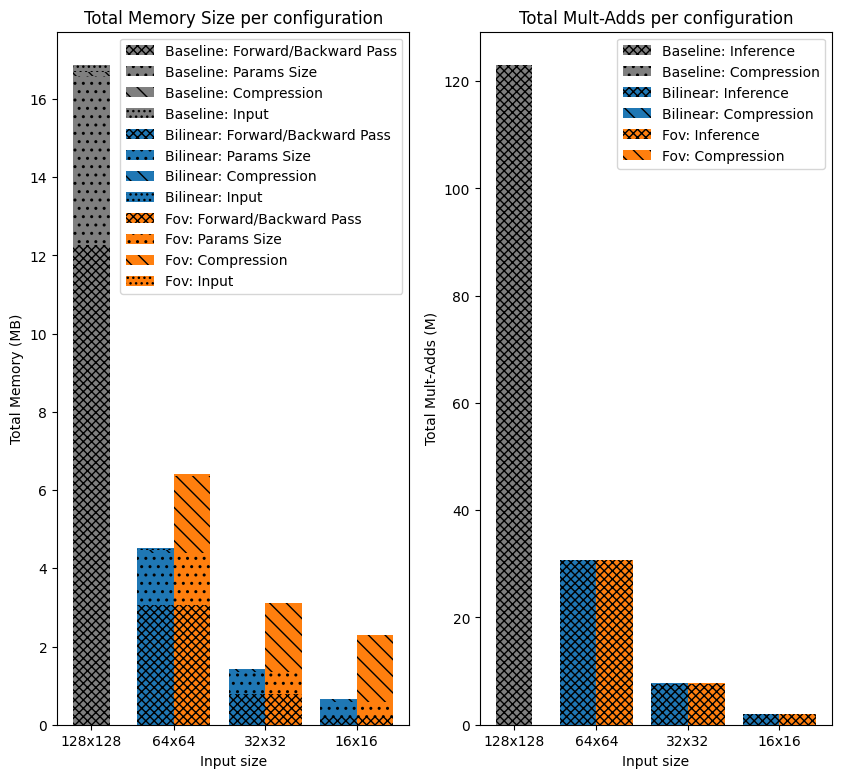

In [40]:
# The upper plot but for my df

# Create bar plots for the aggregated data
fig, axes = plt.subplots(1, 2, figsize=(10, 9))  # Single plot

# Define hatches for texture
params_hatch = '..'
fbpass_hatch = "xxxx"
compression_hatch = '\\\\'
input_hatch = '...'

color_NN = 'tab:blue'
color_fov = 'tab:orange'
color_baseline = 'tab:gray'

# Baseline bar position
baseline_position = 1.1

# Add baseline as a stacked bar
axes[0].bar(
    baseline_position, baseline_form['Memory (F/B Pass)'].values[0],
    width=0.4, color=color_baseline, hatch=fbpass_hatch, label="Baseline: Forward/Backward Pass"
)
axes[0].bar(
    baseline_position, baseline_form['Memory (Params)'].values[0],
    width=0.4, color=color_baseline, hatch=params_hatch,
    bottom=baseline_form['Memory (F/B Pass)'].values[0], label="Baseline: Params Size"
)
axes[0].bar(
    baseline_position, baseline_form['Memory (Compr)'].values[0],
    width=0.4, color=color_baseline, hatch=compression_hatch,
    bottom=baseline_form['Memory (F/B Pass)'].values[0] + baseline_form['Memory (Params)'].values[0],
    label="Baseline: Compression"
)
# add input
axes[0].bar(
    baseline_position, baseline_form['Memory (Input)'].values[0],
    width=0.4, color=color_baseline, hatch=input_hatch,
    bottom=baseline_form['Memory (F/B Pass)'].values[0] + baseline_form['Memory (Params)'].values[0] + baseline_form['Memory (Compr)'].values[0],
    label="Baseline: Input"
)

# Plot Nearest Neighbor (NN) bars with compression on top
axes[0].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Memory (F/B Pass)'], width=0.4, color=color_NN, hatch=fbpass_hatch, label="Bilinear: Forward/Backward Pass")
axes[0].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Memory (Params)'], width=0.4, color=color_NN, hatch=params_hatch, 
         bottom=data_NN_form['Memory (F/B Pass)'], label="Bilinear: Params Size")
axes[0].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Memory (Compr)'], width=0.4, color=color_NN, hatch=compression_hatch,
            bottom=data_NN_form['Memory (F/B Pass)'] + data_NN_form['Memory (Params)'], label="Bilinear: Compression")
axes[0].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Memory (Input)'], width=0.4, color=color_NN, hatch=input_hatch,
            bottom=data_NN_form['Memory (F/B Pass)'] + data_NN_form['Memory (Params)'] + data_NN_form['Memory (Compr)'], label="Bilinear: Input")


# Plot Foveated (Fov) bars with compression on top
axes[0].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Memory (F/B Pass)'], width=0.4, color=color_fov, hatch=fbpass_hatch, label="Fov: Forward/Backward Pass")
axes[0].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Memory (Params)'], width=0.4, color=color_fov, hatch=params_hatch, 
         bottom=data_fov_form['Memory (F/B Pass)'], label="Fov: Params Size")
axes[0].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Memory (Compr)'], width=0.4, color=color_fov, hatch=compression_hatch,
            bottom=data_fov_form['Memory (F/B Pass)'] + data_fov_form['Memory (Params)'], label="Fov: Compression")
axes[0].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Memory (Input)'], width=0.4, color=color_fov, hatch=input_hatch,
            bottom=data_fov_form['Memory (F/B Pass)'] + data_fov_form['Memory (Params)'] + data_fov_form['Memory (Compr)'], label="Fov: Input")

# Formatting
axes[0].legend()

axes[0].set_title('Total Memory Size per configuration')

axes[0].set_ylabel('Total Memory (MB)')
axes[0].set_xlabel('Input size')
axes[0].set_xticks([baseline_position] + list(input_size_positions.values()))
axes[0].set_xticklabels(['128x128'] + list(input_size_positions.keys())
)

# Now the second plot, similar but for mult-adds
# Add baseline as a stacked bar
axes[1].bar(
    baseline_position, baseline_form['Mult-adds (Inference)'].values[0],
    width=0.4, color=color_baseline, hatch=fbpass_hatch, label="Baseline: Inference"
)
axes[1].bar(
    baseline_position, baseline_form['Mult-adds (Compr)'].values[0],
    width=0.4, color=color_baseline, hatch=params_hatch,
    bottom=baseline_form['Mult-adds (Inference)'].values[0], label="Baseline: Compression"
)

# Plot Nearest Neighbor (NN) bars with compression on top
axes[1].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Mult-adds (Inference)'], width=0.4, color=color_NN, hatch=fbpass_hatch, label="Bilinear: Inference")
axes[1].bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Mult-adds (Compr)'], width=0.4, color=color_NN, hatch=compression_hatch, 
         bottom=data_NN_form['Mult-adds (Inference)'], label="Bilinear: Compression")

# Plot Foveated (Fov) bars with compression on top
axes[1].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Mult-adds (Inference)'], width=0.4, color=color_fov, hatch=fbpass_hatch, label="Fov: Inference")
axes[1].bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Mult-adds (Compr)'], width=0.4, color=color_fov, hatch=compression_hatch, 
         bottom=data_fov_form['Mult-adds (Inference)'], label="Fov: Compression")

# Formatting
axes[1].legend()
axes[1].set_title('Total Mult-Adds per configuration')
axes[1].set_ylabel('Total Mult-Adds (M)')
axes[1].set_xlabel('Input size')
axes[1].set_xticks([baseline_position] + list(input_size_positions.values()))
axes[1].set_xticklabels(['128x128'] + list(input_size_positions.keys()))

# set y range to be bigger than the baseline

plt.show()



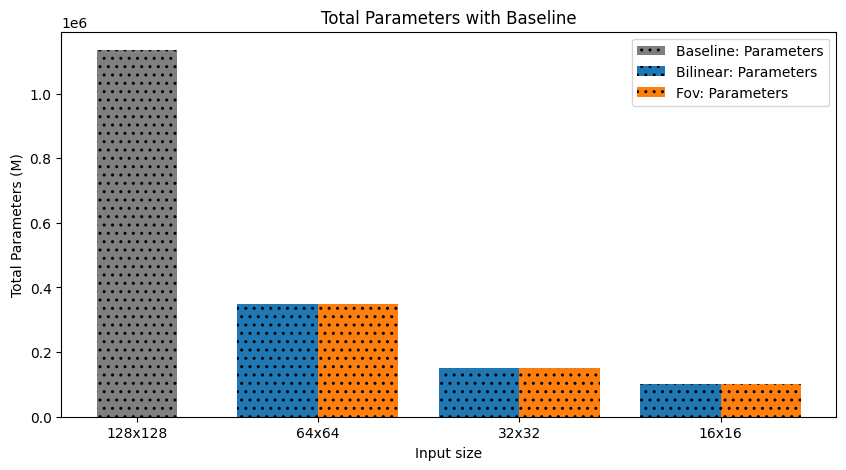

In [39]:
# Plot the parameter count
fig, ax = plt.subplots(figsize=(10, 5))

# only one bar for parameter count
ax.bar(baseline_position, baseline_form['Total Parameters'].values[0], width=0.4, color=color_baseline, hatch=params_hatch, label="Baseline: Parameters")
ax.bar(data_NN_form['Input Size Position'] - 0.2, data_NN_form['Total Parameters'], width=0.4, color=color_NN, hatch=params_hatch, label="Bilinear: Parameters")
ax.bar(data_fov_form['Input Size Position'] + 0.2, data_fov_form['Total Parameters'], width=0.4, color=color_fov, hatch=params_hatch, label="Fov: Parameters")

ax.legend()
ax.set_title('Total Parameters with Baseline')
ax.set_ylabel('Total Parameters (M)')
ax.set_xlabel('Input size')
ax.set_xticks([baseline_position] + list(input_size_positions.values()))
ax.set_xticklabels(['128x128'] + list(input_size_positions.keys()))

plt.show()
